# このノートでやった（できる）こと
### Logistic regressionを用いて、目的変数の確率を算出し、算出した値を元に様々な掛け方をした場合の回収率を計算

#### 計算に用いた特徴量
- 各レーサーのクラス
- 各レーサーの各枠における平均スタートタイム
- 各レーサーの連帯率
- 展示タイム
- 各モーターの2連率
- 各モーターの3連率
- 各ボートの2連率
- 各ボートの3連率

#### 目的変数
- 1枠: 1着になる (1) or ならない (0)
- 2-6枠: 3着以内にはいる (1) or 入らない (0)


### 結果
#### Logistic Regression結果
- Logistic_regression_1よりは全体的にいい結果になるが、まだ実用化にたるものとは言えない。ギャンブル性がある。
- regressionに使う結果を、半年分入れるよりも、1ヶ月分など短期にする方が予測精度が上がる可能性がある
#### bet結果


In [1]:
# 必要なモジュールのインポート

from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import termcolor
from datetime import datetime

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [2]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.main()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])
# print(the_merged_df["CS_frame_1_1"])

/Users/grice/mywork/boatrace/src/analyze/../data_preparing/loader.py:357: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  race_results_supplementary_df = pd.concat(race_results_supplementary_df_list)


In [ ]:
"""

# test用にdfを期間で区切って小さくして使いたい時
from_dt = datetime(2019, 1, 1)
to_dt = datetime(2019, 9, 1)

the_merged_df = the_merged_df[(the_merged_df["date"] >= from_dt) & (the_merged_df["date"] <= to_dt)]

"""

In [3]:
# logistic regressionを利用した学習

def make_df_for_analyze(merged_df, fv_list, column_list_label, odds_list):
    """
    parameters
        fv_list: dfのうち、特徴量として用いるカラム名のリスト
        column_list_label: dfのうち、labelとして用いるカラム名のリスト
    """
    
    # 特徴量のdfを作成
    fv_df = merged_df[fv_list]
    
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
    for key, value in class_dict.items():
        fv_df.replace(key, value, inplace = True)

    # 会場名をbooleanに変換
    venue_df = pd.get_dummies(fv_df["venue"])
    
    # fv_dfの方の会場の列を削除
    fv_df = fv_df.drop("venue", axis=1)
    
    # 会場名がbooleanになったfv_dfの作成
    fv_df = pd.concat([fv_df, venue_df], axis=1)
    
    # なぜかdtypeがstrになっちゃうのでfloatに戻す
    fv_df = fv_df.astype(float)
    
    # labelのdfを作成
    label_df = merged_df[column_list_label]
    
    # ラベルをbooleanに変換
    label_df = analyzer_conf.make_label_boolean_ver1(label_df, column_list_label)
    
    """
    # 特徴量を標準化
    fv_label_df = analyzer_conf.standerdize_feature_values(
        fv_label_df, column_list_label)
    """
    
    # オッズのdfを作成
    odds_df = merged_df[odds_list]
    
    # 解析用dfを作成
    fv_label_odds_df = pd.concat([fv_df, label_df, odds_df], axis=1)
    # nanを含む行を削除
    fv_label_odds_df = fv_label_odds_df.dropna()
    
    # oddsはないバージョンのdf
    fv_label_df = pd.concat([fv_df, label_df], axis=1)
    # nanを含む行を削除
    fv_label_df = fv_label_df.dropna()
    
    """
    print(len(fv_df), len(label_df), len(odds_df))
    print("解析用dfの行数は.{0}".format(len(fv_label_df)))
    print(fv_label_df)
    """
    
    return fv_label_df, fv_label_odds_df


def separate_train_test_dataset(for_analysis_df, train_data_ratio):
       
    # 解析用df（特徴量+label）を、学習用データとテストデータのarrayに分ける
    train_size = int(len(for_analysis_df) * train_data_ratio)
    train_data = for_analysis_df[:train_size].values
    test_data = for_analysis_df[train_size:].values
    
    return train_data, test_data, train_size

    
def learn_logistic_regression(train_data, column_list_label):
    
    """
    1枠が1着になるかどうか？2枠以降に関しては3着以内に入るかどうか？を scikit-lernのlogistic regressionを用いて学習する。
    複数のラベルをリストとして入力することが可能で、戻り値はそれぞれのlabelに対して学習を行なった結果のモデルを各要素にもつリスト
    
    return
        clf_list: 各ラベルについて学習したモデルのlist
    
    TODO
        ラベルの作成方法などもinput parameterとして指定できた方がいい。
        むしろregressionの方法もinputにして超汎用的な関数を外側に作るか？
    
    """
    # ラベルとしてもちいる部分の数。labelと特徴量を分ける際に使用、
    num_labels = len(column_list_label)
    
    # 特徴量部分のarray
    train_x = train_data[:, :-num_labels]

    # ロジスティック回帰を行なった結果得られるオブジェクトをリストに格納
    clf_list  = []

    for i, column_label in enumerate(column_list_label):
        # ラベルを指定
        train_t = train_data[:, - num_labels + i]

        # ロジスティック回帰
        clf = LogisticRegression()
        clf.fit(train_x, train_t)

        clf_list.append(clf)
    
    return clf_list, num_labels


# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []

# 開催地
fv_list.append("venue")    

for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各レーサーの該当枠における平均ST
    fv_list.append("aveST_frame{0}".format(i))
    # 各レーサーの該当枠における連帯率
    fv_list.append("placeRate_frame{0}".format(i))
    
    # 勝率・二連率・三連率（全国）
    fv_list.append("win_rate_national_{0}".format(i))
    fv_list.append("place2Ratio_national_{0}".format(i))
    fv_list.append("place3Ratio_national_{0}".format(i))
    
    # 勝率・二連率・三連率（当地）
    fv_list.append("win_rate_local_{0}".format(i))
    fv_list.append("place2Ratio_local_{0}".format(i))
    fv_list.append("place3Ratio_local_{0}".format(i))
    
    # 展示タイム
    fv_list.append("exhibitionTime_{0}".format(i))
    
    # 各モーターの2連率, 3連率
    fv_list.append("motor_place2Ratio_{0}".format(i))
    fv_list.append("motor_place3Ratio_{0}".format(i))
    
    # ボートの2連率、3連率
    fv_list.append("boat_place2Ratio_{0}".format(i))
    fv_list.append("boat_place3Ratio_{0}".format(i))
    
    # 直前のレースの成績
    # for j in range(1, 12):
        # fv_list.append("CS_frame_{0}_{1}".format(i, j))
        # fv_list.append("CS_rank_{0}_{1}".format(i, j))

# 解析に使うラベルカラム: 1枠が1着になるか, 2枠以降は3着以降に入るかどうか？を予測
column_list_label = ["rank_{0}".format(i) for i in range(1,7)]

# 回収率計算に使用するオッズラベルのリスト
odds_list =  ["win", "winOdds", 
             "place_1", "placeOdds_1",
             "place_2", "placeOdds_2",
             "exacta", "exactaOdds",
             "quinella", "quinellaOdds",
             "wide_1", "wideOdds_1", 
             "wide_2", "wideOdds_2",
             "wide_3", "wideOdds_3",
             "trifecta", "trifectaOdds",
             "trio", "trioOdds"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 0.7

# --------------------------------

# main

fv_label_df, fv_label_odds_df = make_df_for_analyze(the_merged_df, fv_list, column_list_label, odds_list)
train_data, test_data, train_size = separate_train_test_dataset(fv_label_df, train_data_ratio)
clf_list, num_labels = learn_logistic_regression(train_data, column_list_label)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/Users/grice/mywork/boatrace/src/analyze/analyzer_conf.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  for_analysis_df.loc[for_analysis_df[column_name] != 1, column_name] = 0
/Users/grice/mywork/boatra

1号艇についてtrainデータを使った正解率は0.6753397059453898,
           testデータを使った正解率は0.6538653865386539
切片は[0.18817618]
2号艇についてtrainデータを使った正解率は0.6684384242787946,
           testデータを使った正解率は0.6533653365336534
切片は[-0.16106955]
3号艇についてtrainデータを使った正解率は0.6551073770843157,
           testデータを使った正解率は0.6366636663666366
切片は[-0.01695851]
4号艇についてtrainデータを使った正解率は0.6619657936473916,
           testデータを使った正解率は0.6487648764876488
切片は[0.07010463]
5号艇についてtrainデータを使った正解率は0.699558489433752,
           testデータを使った正解率は0.6937693769376938
切片は[-0.06267155]
6号艇についてtrainデータを使った正解率は0.7479960564104763,
           testデータを使った正解率は0.7496749674967497
切片は[-0.0174875]


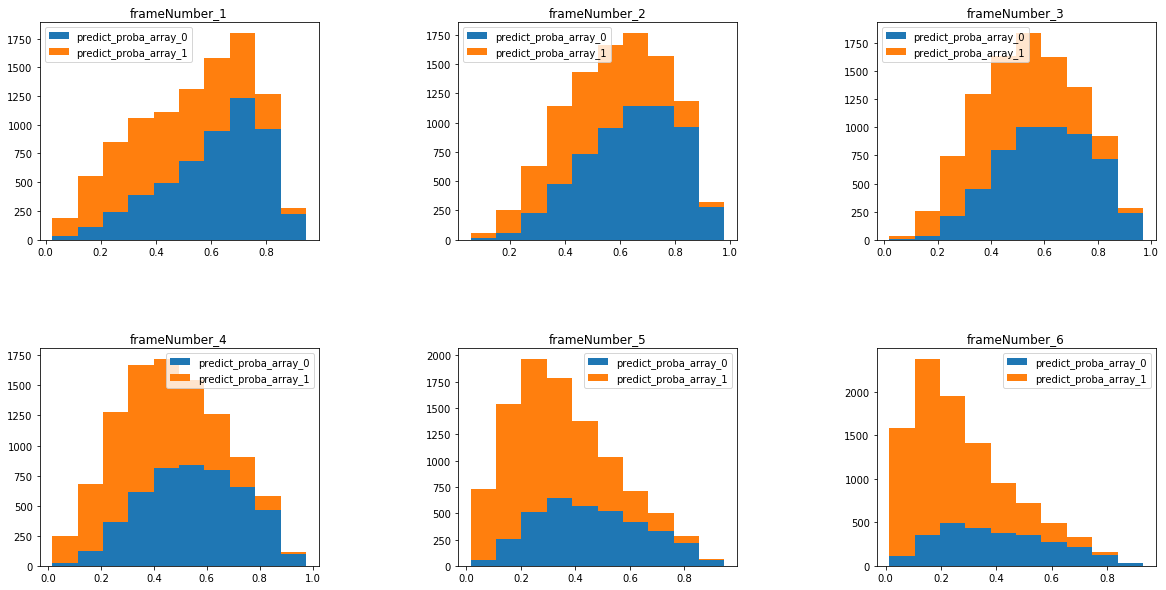

In [4]:
"""
上のセルで学習したclfを用いて色々と解析する。
今このセルで行なっている解析は
1. 各labelについて正解率を計算
2. 最適化された結果の切片および各係数を表示
3. テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成

"""
# 描画用の枠を用意

plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

# 回収率計算用に、[predict_proba_array, test_t]を各要素にもつリストを作成
predict_proba_array_list = []

# 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
train_x = train_data[:, :-num_labels]
test_x = test_data[:, :-num_labels]

for i, clf in enumerate(clf_list):
    train_t = train_data[:, - num_labels + i]
    test_t = test_data[:, - num_labels + i]
    
    # 正解率を計算
    train_score = clf.score(train_x, train_t)
    test_score = clf.score(test_x, test_t)
    print("{2}号艇についてtrainデータを使った正解率は{0},\n \
          testデータを使った正解率は{1}".format(train_score, test_score, i + 1))

    # 最適化された結果の切片と重みを取得
    intercept =clf.intercept_
    coef = clf.coef_
    print("切片は{0}".format(intercept))
    # for j in range (coef.shape[1]):
        # print(fv_list[j], coef[0, j], "\n")

    # テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成
    predict_proba_array = clf.predict_proba(test_x)
    
    # listに格納しておく
    predict_proba_array_list.append(predict_proba_array[:, 1])

    # 結果が1 (1枠が一着 , 2枠以降が3着以内) だったものの推定確率
    predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

    # 結果が0 (1枠以外が一着, 1枠以外の場合は4着以降) だったものの推定確率
    predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

    # 積み上げヒストグラムを作成
    title = "frameNumber_{0}".format(i + 1)
    labels = {'predict_proba_array_1', 'predict_proba_array_0'}
    plt.subplot(2, 3, i+1)
    plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
    plt.title(title)
    plt.legend()
plt.show()

# 考察
- 正解率はいずれのラベルに対しても6割から7割程度にとどまるが、test dataとtraining dataで同程度の正解率をだす。
確率ごとにプロットをしてみると、
- predict_probaが小さい時は実際に0ラベル、predict_probaが大きい時は実際に1ラベルであることがかなり多くなっている。
- 正解率を下げているのは実際に判断が難しいところ（0.3 < predict_proba < 0.7くらいの場所） であり、predict_probaが高いところ、低いところを抽出して用いることで十分に予測器として使用可能
- 1着以外が1位になる，荒れるレースの予測や、1着を1枠に固定し、2, 3を高いprobabilityを示すものでbox買するといったオプションが考えられる。

そこで、以下のセルにおいては掛け方を色々してみた時の回収率計算を行う。

In [5]:
# 計算用dfを作成
# 6列目までが上の解析によって求めた確率(1号艇が1位になる率, 2-6号艇が3位以内に入る確率)
# 7列目以降にオッズ関係の値を格納

for_calc_refund_rate_df = pd.DataFrame(np.vstack(predict_proba_array_list).T, columns=["PredProb_{0}".format(i) for i in range(1, 7)])
for odds_column_name in odds_list:
    # TODO intで入れられるものはintで。無理なものはとりあえずobjectのままで格納
    for_calc_refund_rate_df[odds_column_name] = fv_label_odds_df[odds_column_name][train_size:].values

print(for_calc_refund_rate_df)

      PredProb_1  PredProb_2  PredProb_3  PredProb_4  PredProb_5  PredProb_6  \
0       0.312209    0.873270    0.680612    0.072179    0.575804    0.275244   
1       0.586536    0.580182    0.807212    0.146130    0.057452    0.725662   
2       0.481872    0.291865    0.633446    0.838391    0.316717    0.140541   
3       0.491657    0.800715    0.472032    0.475371    0.427011    0.119752   
4       0.711317    0.644188    0.187943    0.613051    0.604383    0.138546   
5       0.702241    0.521455    0.701919    0.630269    0.214971    0.123044   
6       0.532151    0.431688    0.601446    0.481772    0.376776    0.528357   
7       0.539237    0.565879    0.378193    0.689190    0.492304    0.315878   
8       0.534288    0.624762    0.425300    0.315853    0.457280    0.608981   
9       0.592138    0.444758    0.517274    0.399011    0.579554    0.463637   
10      0.408941    0.435357    0.799306    0.429881    0.407467    0.319029   
11      0.756307    0.512811    0.424316

In [6]:
# 確率x_1以上のときのみ、1に単勝賭けした時の回収率
x_1_list = [0.6, 0.7, 0.8]
for x_1 in x_1_list:
    bet = sum(for_calc_refund_rate_df["PredProb_1"] > x_1)

    return_boolean = (for_calc_refund_rate_df["PredProb_1"] > x_1) & (for_calc_refund_rate_df["win"] == "1")
    return_ = sum(for_calc_refund_rate_df["winOdds"][return_boolean])

    print("確率{0}以上で1に単勝betした場合、的中率は{1}, 回収率は{2}".format(x_1, sum(return_boolean) / bet, return_ / (bet * 100)))

確率0.6以上で1に単勝betした場合、的中率は0.6949152542372882, 回収率は0.9353510895883778
確率0.7以上で1に単勝betした場合、的中率は0.7362596827738842, 回収率は0.9355219476208041
確率0.8以上で1に単勝betした場合、的中率は0.7920560747663551, 回収率は0.9376168224299065


In [7]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率がx_2超えがあった場合に、1-XY..の形で2連単bet

x_1_list = [0.7, 0.75, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "1-{0}".format(j)
                        bet = bet + 100
                        if row["exacta"] == bet_num:
                            income = income + row["exactaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で2連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.7以上かつ、p2-6が0.5以上で2連単betすると収益は-69910, 回収率は0.8560041194644696
p1が0.7以上かつ、p2-6が0.6以上で2連単betすると収益は-49690, 回収率は0.8288322425077506
p1が0.7以上かつ、p2-6が0.7以上で2連単betすると収益は-25510, 回収率は0.8198446327683616
p1が0.7以上かつ、p2-6が0.8以上で2連単betすると収益は-9650, 回収率は0.801440329218107
p1が0.75以上かつ、p2-6が0.5以上で2連単betすると収益は-47680, 回収率は0.8448926480156148
p1が0.75以上かつ、p2-6が0.6以上で2連単betすると収益は-30120, 回収率は0.8335911602209944
p1が0.75以上かつ、p2-6が0.7以上で2連単betすると収益は-14060, 回収率は0.8341981132075472
p1が0.75以上かつ、p2-6が0.8以上で2連単betすると収益は-5390, 回収率は0.8134948096885813
p1が0.8以上かつ、p2-6が0.5以上で2連単betすると収益は-22690, 回収率は0.8434092477570738
p1が0.8以上かつ、p2-6が0.6以上で2連単betすると収益は-10780, 回収率は0.8698067632850242
p1が0.8以上かつ、p2-6が0.7以上で2連単betすると収益は-5860, 回収率は0.838121546961326
p1が0.8以上かつ、p2-6が0.8以上で2連単betすると収益は-2200, 回収率は0.828125


In [8]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9と1-9-Xの形で3連単bet
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 200
                                bet_num_1 = "1-{0}-{1}".format(j, k)
                                bet_num_2 = "1-{0}-{1}".format(k, j)
                                # print(bet_num_1, bet_num_2, row["trifecta"], row["trifectaOdds"])
                                if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-1020170, 回収率は0.7520489014194051
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-543200, 回収率は0.7403441682600382
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-246070, 回収率は0.6696160042964554
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-470790, 回収率は0.7972829831209094
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-193700, 回収率は0.829007768361582
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-122580, 回収率は0.6847222222222222
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は-139980, 回収率は0.7886775362318841
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は-68080, 回収率は0.7649171270718232
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は-23410, 回収率は0.77138671875


In [9]:
# 上と同じノリで2着固定。すなわち、
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9の形で3連単bet
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-1489460, 回収率は0.7694619861317484
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-1068570, 回収率は0.7661567752100841
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-673880, 回収率は0.7656558631242175
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-383720, 回収率は0.7447991487097633
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は-110780, 回収率は0.8008986340762042
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-1037400, 回収率は0.7824427480916031
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-724620, 回収率は0.7834887056292578
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-453370, 回収率は0.7796179272797977
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-287520, 回収率は0.7251242829827916
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-94530, 回収率は0.7461600429645543
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-628860, 回収率は0.7735633011666426
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-402130, 回収率は0.7929299691040165
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-262790, 回収率は0.7736910093007234
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-158020, 回収率は0.7210098870056497
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-58620, 回収率は0.6984567901234567
p1が0.8以上か

In [10]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以下が2艇以上あった場合に、1頭で、2割以下艇を外した残りを2, 3着boxにして買う
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.4, 0.3, 0.2]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                outers = (row[["PredProb_{0}".format(n) for n in range(2, 7)]] < x_2)
                num_outers = sum(outers)
                if (num_outers > 1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-293810, 回収率は0.8292794886693783
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-276770, 回収率は0.7980370694687683
p1が0.6以上かつ、p2-6が0.2以上で3連単betすると収益は-64710, 回収率は0.8100117439812097
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-167110, 回収率は0.8339196978731862
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-142370, 回収率は0.8310348920009495
p1が0.7以上かつ、p2-6が0.2以上で3連単betすると収益は-45610, 回収率は0.7858685446009389
p1が0.8以上かつ、p2-6が0.4以上で3連単betすると収益は-61490, 回収率は0.803169014084507
p1が0.8以上かつ、p2-6が0.3以上で3連単betすると収益は-54110, 回収率は0.8092031029619182
p1が0.8以上かつ、p2-6が0.2以上で3連単betすると収益は-17300, 回収率は0.7597222222222222


In [11]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が2艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
x_1_list = [0.5, 0.6, 0.7, 0.75, 0.8]
x_2_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("投票候補なし")

p1が0.5以上かつ、p2-6が0.3以上で3連単betすると収益は-1155160, 回収率は0.7872868559643502
p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-501060, 回収率は0.8319267409097008
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-212840, 回収率は0.8336667708658956
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-56290, 回収率は0.8596959122632104
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-14880, 回収率は0.8176470588235294
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は-750, 回収率は0.8660714285714286
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-811030, 回収率は0.7972830433913217
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-373910, 回収率は0.8253573096683793
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-154330, 回収率は0.8276412776412776
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-31900, 回収率は0.8782442748091603
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-7510, 回収率は0.8479757085020243
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は480, 回収率は1.24
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-415840, 回収率は0.8208358466178372
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-206860, 回収率は0.8283889165422267
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-78140, 回収率は0.8429662379421222
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-1

In [12]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以上が1艇, X_3以上が1艇以上あった場合に、1頭で、x_2以上艇を2, 3着boxにして買う
# ただし、2-6号艇のうち二つ以上の艇がx_２を超えていた場合、それらに対しては2倍のbet額になるアルゴリズムになっている
x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-423760, 回収率は0.8181287553648069
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-282200, 回収率は0.8236690827293177
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-152360, 回収率は0.8460076814230847
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-63800, 回収率は0.8782442748091603
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-183660, 回収率は0.8344510546241212
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-100290, 回収率は0.86628
p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-57000, 回収率は0.8719101123595505
p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は-29830, 回収率は0.8677748226950355
p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-15020, 回収率は0.8479757085020243
p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-47500, 回収率は0.8718294657312466
p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-25070, 回収率は0.8943086003372681
p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は-6540, 回収率は0.9493023255813954
p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は-280, 回収率は0.9955555555555555
p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は-2880, 回収率は0.8925373134328358
p1が0.6以上かつ、p2が0.

In [13]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のとき、2-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_2".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "2-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-73940, 回収率は0.8188633023027927
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-50240, 回収率は0.7940139401394014
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-21450, 回収率は0.7997198879551821
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-36510, 回収率は0.8207658321060383
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-29260, 回収率は0.7375784753363229
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-5900, 回収率は0.8649885583524027
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-17680, 回収率は0.8474547023295945
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-12040, 回収率は0.8064308681672026
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は490, 回収率は1.0203319502074688
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-4710, 回収率は0.8642651296829971
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-6350, 回収率は0.6350574712643678
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は480, 回収率は1.0666666666666667


In [14]:
# TODO: 1号艇の勝率x_1以上, 2号艇の3位以内率x_2以上の時、他の艇で3位以内率x_3以上があった場合に、2-1-xで買う

x_1_list = [0.6, 0.7, 0.75, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            if x_3 <= x_2:

                income = 0
                bet = 0

                for index, row in for_calc_refund_rate_df.iterrows():
                    if (row["PredProb_1"] > x_1):
                        for j in range(2, 7):
                            if row["PredProb_{0}".format(j)] > x_2:
                                for k in range(2, 7):
                                    if k is not j and row["PredProb_{0}".format(k)] > x_3:
                                        bet = bet + 200
                                        bet_num_1 = "1-{0}-{1}".format(j, k)
                                        bet_num_2 = "1-{0}-{1}".format(k, j)

                                        if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                            income = income + row["trifectaOdds"]
                                        # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
                try:
                    text = "p1が{0}以上かつ、p2が{1}以上かつp3が{2}で3連単betすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                    if (income / bet) < 1:
                        text = termcolor.colored(text, "red")
                    print(text)
                except ZeroDivisionError:
                    print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.6以上かつ、p2が0.6以上かつp3が0.3で3連単betすると収益は-423760, 回収率は0.8181287553648069
p1が0.6以上かつ、p2が0.6以上かつp3が0.4で3連単betすると収益は-282200, 回収率は0.8236690827293177
p1が0.6以上かつ、p2が0.6以上かつp3が0.5で3連単betすると収益は-152360, 回収率は0.8460076814230847
p1が0.6以上かつ、p2が0.6以上かつp3が0.6で3連単betすると収益は-63800, 回収率は0.8782442748091603
p1が0.6以上かつ、p2が0.7以上かつp3が0.3で3連単betすると収益は-183660, 回収率は0.8344510546241212
p1が0.6以上かつ、p2が0.7以上かつp3が0.4で3連単betすると収益は-100290, 回収率は0.86628
p1が0.6以上かつ、p2が0.7以上かつp3が0.5で3連単betすると収益は-57000, 回収率は0.8719101123595505
p1が0.6以上かつ、p2が0.7以上かつp3が0.6で3連単betすると収益は-29830, 回収率は0.8677748226950355
p1が0.6以上かつ、p2が0.7以上かつp3が0.7で3連単betすると収益は-15020, 回収率は0.8479757085020243
p1が0.6以上かつ、p2が0.8以上かつp3が0.3で3連単betすると収益は-47500, 回収率は0.8718294657312466
p1が0.6以上かつ、p2が0.8以上かつp3が0.4で3連単betすると収益は-25070, 回収率は0.8943086003372681
p1が0.6以上かつ、p2が0.8以上かつp3が0.5で3連単betすると収益は-6540, 回収率は0.9493023255813954
p1が0.6以上かつ、p2が0.8以上かつp3が0.6で3連単betすると収益は-280, 回収率は0.9955555555555555
p1が0.6以上かつ、p2が0.8以上かつp3が0.7で3連単betすると収益は-2880, 回収率は0.8925373134328358
p1が0.6以上かつ、p2が0.

In [15]:
# 1号艇の勝率x_1以上,3号艇の勝率x_2以上のとき、3-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_3".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "3-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-85320, 回収率は0.7306818181818182
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-41430, 回収率は0.7659322033898305
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-8330, 回収率は0.881
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-57210, 回収率は0.6372225745085606
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-23500, 回収率は0.7130647130647131
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-4030, 回収率は0.8665562913907284
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-39420, 回収率は0.562
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-10040, 回収率は0.7758928571428572
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は520, 回収率は1.0327044025157233
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-9010, 回収率は0.6466666666666666
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は2540, 回収率は1.228828828828829
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は840, 回収率は1.2210526315789474


In [16]:
# 1号艇の勝率x_1以上,4号艇の勝率x_2以上のとき、4-1にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_4".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "4-1":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-58290, 回収率は0.7217661097852028
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-21870, 回収率は0.795607476635514
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-10880, 回収率は0.7098666666666666
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-25320, 回収率は0.7351464435146443
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-10070, 回収率は0.7742152466367713
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-7870, 回収率は0.41703703703703704
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-14660, 回収率は0.7239171374764595
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-1490, 回収率は0.9328828828828829
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-960, 回収率は0.8188679245283019
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-3750, 回収率は0.7431506849315068
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-1690, 回収率は0.675
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は640, 回収率は1.5333333333333334


In [17]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のとき、1-2にbet
x_1_list = [0.3, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                if row["PredProb_2".format(j)] > x_2:
                    bet = bet + 100

                    if row["exacta"] == "1-2":
                        income = income + row["exactaOdds"]
                    # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
        try:
            text = "p1が{0}以上かつ、p2が{1}以上で2連単2-1にbetすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet)
            if (income / bet) < 1:
                text = termcolor.colored(text, "red")
            print(text)
        except ZeroDivisionError:
            print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1が0.3以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-61220, 回収率は0.8500244977951984
p1が0.3以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-44330, 回収率は0.8182451824518245
p1が0.3以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-13630, 回収率は0.8727357609710551
p1が0.6以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-32880, 回収率は0.8385861561119293
p1が0.6以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-21270, 回収率は0.8092376681614349
p1が0.6以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-8220, 回収率は0.8118993135011442
p1が0.7以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-18440, 回収率は0.8408973252804142
p1が0.7以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-10890, 回収率は0.8249196141479099
p1が0.7以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-4760, 回収率は0.8024896265560166
p1が0.8以上かつ、p2が0.6以上で2連単2-1にbetすると収益は-3880, 回収率は0.8881844380403459
p1が0.8以上かつ、p2が0.7以上で2連単2-1にbetすると収益は-2910, 回収率は0.8327586206896552
p1が0.8以上かつ、p2が0.8以上で2連単2-1にbetすると収益は-1190, 回収率は0.8347222222222223


In [18]:
# 1号艇の勝率x_1以上,2号艇の勝率x_2以上のときで、x_3を超えている他の艇に対して2-1-XXにbet
x_1_list = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]
x_3_list = [0.2, 0.3, 0.4, 0.5, 0.6]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        for x_3 in x_3_list:
            income = 0
            bet = 0

            for index, row in for_calc_refund_rate_df.iterrows():
                if (row["PredProb_1"] > x_1):
                    if row["PredProb_2".format(j)] > x_2:
                        for i in range(3, 7):
                            if row["PredProb_{0}".format(i)] > x_3:
                                bet = bet + 100

                                if row["trifecta"] == "2-1-{0}".format(i):
                                    income = income + row["trifectaOdds"]
                                # print(bet_num, row["trifecta"], row["trifectaOdds"], bet, income)
            try:
                text = "p1 > {0}、p2 > {1}, p3 > {2}で3連単2-1-i にbetすると収益は{3}, 回収率は{4}".format(x_1, x_2, x_3, income-bet, income/bet)
                if (income / bet) < 1:
                    text = termcolor.colored(text, "red")
                print(text)
            except ZeroDivisionError:
                print("p1={0}, p2={1}, p3={2}の時、投票候補なし".format(x_1, x_2, x_3))

p1 > 0.3、p2 > 0.6, p3 > 0.2で3連単2-1-i にbetすると収益は-253380, 回収率は0.7974256475855452
p1 > 0.3、p2 > 0.6, p3 > 0.3で3連単2-1-i にbetすると収益は-219010, 回収率は0.7712450386463339
p1 > 0.3、p2 > 0.6, p3 > 0.4で3連単2-1-i にbetすると収益は-136670, 回収率は0.7983325955437509
p1 > 0.3、p2 > 0.6, p3 > 0.5で3連単2-1-i にbetすると収益は-44380, 回収率は0.898000459664445
p1 > 0.3、p2 > 0.6, p3 > 0.6で3連単2-1-i にbetすると収益は-14900, 回収率は0.9389344262295082
p1 > 0.3、p2 > 0.7, p3 > 0.2で3連単2-1-i にbetすると収益は-165290, 回収率は0.7714147420826994
p1 > 0.3、p2 > 0.7, p3 > 0.3で3連単2-1-i にbetすると収益は-133340, 回収率は0.7548446405589263
p1 > 0.3、p2 > 0.7, p3 > 0.4で3連単2-1-i にbetすると収益は-66270, 回収率は0.8252834168204587
p1 > 0.3、p2 > 0.7, p3 > 0.5で3連単2-1-i にbetすると収益は-12480, 回収率は0.947585048299034
p1 > 0.3、p2 > 0.7, p3 > 0.6で3連単2-1-i にbetすると収益は-1790, 回収率は0.9864599092284417
p1 > 0.3、p2 > 0.8, p3 > 0.2で3連単2-1-i にbetすると収益は-69010, 回収率は0.7730680697139098
p1 > 0.3、p2 > 0.8, p3 > 0.3で3連単2-1-i にbetすると収益は-58570, 回収率は0.7408407079646018
p1 > 0.3、p2 > 0.8, p3 > 0.4で3連単2-1-i にbetすると収益は-23230, 回収率は0.8

### x_2 > 0.8 さえ入れればほとんどのx_1, x_3でプラスになるぞおおおおおお
### x_1 > 0.4, x_2 > 0.8, x_3 > 0.6を満たすレースへbetしていってみる探す